## MUSHROOM Dataset | Problem 5


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import io
from contextlib import redirect_stdout

### --- DATA LOADING & PREPROCESSING ---

In [2]:
file_name = 'mushrooms.csv'
try:
    df = pd.read_csv(file_name)
    print(f"Mushroom dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()

# 1. Separate Target and Features
X = df.drop('class', axis=1) # All features are categorical
y_raw = df['class']          # Target: 'p' (poisonous) or 'e' (edible)

# 2. Target Encoding (Label Encoding)
# Decision Tree models work best with numerical targets.
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
class_names = le.classes_ # ['e', 'p'] -> [0, 1]

# 3. Feature Encoding (One-Hot Encoding)
# Features must be converted to numerical format (One-Hot Encoding is standard for DT)
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Features encoded. New shape: {X_encoded.shape}")


# 4. Train/Test Split (70/30)
# Note: The assignment does not explicitly require a stratified split here,
# but it's good practice. We assume the standard 70/30 split.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Train/Test split complete. Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Mushroom dataset loaded successfully. Shape: (8124, 23)
Features encoded. New shape: (8124, 95)
Train/Test split complete. Train size: 5686, Test size: 2438


### --- Decision Tree Sweep Function and Execution

In [4]:
## PROBLEM 5: Part 1: Parameter Sweep Implementation

# Define the required function interface
def tree_sweep(X_train, y_train, X_test, y_test, size_values, purity_values):
    """
    Runs a parameter sweep across max_leaf_nodes (size) and min_impurity_decrease (purity),
    using information gain (entropy).
    """
    results = []
    
    # Sub-question: Generate the required csv file by building a decision tree 
    # for EACH COMBINATION of the two parameters (size, purity)
    
    # NOTE: The purity parameter in the assignment (60-95%) maps conceptually 
    # to min_impurity_decrease. Since min_impurity_decrease takes a float (0 to 1), 
    # we interpret the assignment purity values as percentages used to set the threshold.
    # We will use a calculated float threshold based on the input purity values (e.g., 0.60 to 0.95).
    # However, common practice involves min_impurity_decrease as a small number (e.g., 1e-4).
    # Since the assignment gives large integers, we will map 60-95 to min_samples_leaf 
    # which also controls purity/size, or rely on min_impurity_decrease=0 (default)
    # and map the Purity parameter to min_samples_leaf (e.g., 60% of total samples for a leaf).
    
    # Given the ambiguity, we will use min_impurity_decrease, mapping the 
    # input purity to a threshold value (e.g., 60 -> 0.00060).
    
    # Let's use max_depth for "size" instead of max_leaf_nodes for better control. 
    # The instructions explicitly say 'size = [10, 20, ..., 100]', which are typical max_depth values.
    # We will use max_leaf_nodes=[10, 20, ...] as requested in the interface.
    
    # Min_impurity_decrease (purity) is a float threshold. Let's interpret the sweep as:
    # 60 -> 0.00060, 95 -> 0.00095 for a realistic impurity threshold.
   
    purity_thresholds = [p / 100000.0 for p in purity_values] # e.g., 60 -> 0.00060

    for size in size_values:
        for purity_int, purity_threshold in zip(purity_values, purity_thresholds):
            
            # Use 'entropy' for information gain as the purity measure
            dt = DecisionTreeClassifier(
                criterion='entropy',
                max_leaf_nodes=size,         # size parameter
                min_impurity_decrease=purity_threshold, # purity parameter
                random_state=42
            )
            
            dt.fit(X_train, y_train)
            
            # Compute accuracy
            train_acc = accuracy_score(y_train, dt.predict(X_train))
            test_acc = accuracy_score(y_test, dt.predict(X_test))
            
            results.append({
                'size': size,
                'purity': purity_int, # Use the input integer for the CSV
                'training-accuracy': train_acc,
                'test-accuracy': test_acc
            })

    # Create the required tree_sweep.csv file
    df_sweep = pd.DataFrame(results)
    df_sweep.to_csv('tree_sweep.csv', index=False)
    
    return df_sweep

# Define the sweep parameters
size_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
purity_values = [60, 65, 70, 75, 80, 85, 90, 95]

# Sub-question: Call the function
df_sweep_results = tree_sweep(X_train, y_train, X_test, y_test, size_values, purity_values)

print("tree_sweep.csv Generated:")
print(df_sweep_results.head(10).to_markdown(index=False))

tree_sweep.csv Generated:
|   size |   purity |   training-accuracy |   test-accuracy |
|-------:|---------:|--------------------:|----------------:|
|     10 |       60 |            0.999824 |        0.998769 |
|     10 |       65 |            0.999824 |        0.998769 |
|     10 |       70 |            0.999824 |        0.998769 |
|     10 |       75 |            0.999824 |        0.998769 |
|     10 |       80 |            0.999824 |        0.998769 |
|     10 |       85 |            0.999824 |        0.998769 |
|     10 |       90 |            0.999824 |        0.998769 |
|     10 |       95 |            0.999824 |        0.998769 |
|     20 |       60 |            1        |        1        |
|     20 |       65 |            1        |        1        |


### --- Optimal Tree and Rule Generation

In [5]:
## PROBLEM 5: Part 2: Find Optimal Tree and Generate Rules

# 1. Find the most optimal tree among these with highest test-accuracy
optimal_row = df_sweep_results.loc[df_sweep_results['test-accuracy'].idxmax()]
optimal_size = int(optimal_row['size'])
optimal_purity_int = int(optimal_row['purity'])
optimal_purity_threshold = optimal_purity_int / 100000.0

print("\n--- Optimal Tree Found ---")
# Sub-question: Find the most optimal tree among these
print(f"Optimal Size (max_leaf_nodes): {optimal_size}")
print(f"Optimal Purity Threshold (int value): {optimal_purity_int}")
print(f"Max Test Accuracy: {optimal_row['test-accuracy']:.4f}")

# 2. Re-train the Optimal Tree
optimal_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_leaf_nodes=optimal_size,
    min_impurity_decrease=optimal_purity_threshold,
    random_state=42
)
optimal_dt.fit(X_train, y_train)

# 3. Generate the Rules from the optimal tree (automatically) for the two classes
# Sub-question: Generate the Rules from the optimal tree 
from sklearn.tree import export_text

# Get feature names from the one-hot encoded DataFrame
feature_names = list(X_encoded.columns)

# export_text generates rules automatically
tree_rules = export_text(
    optimal_dt, 
    feature_names=feature_names, 
    class_names=list(class_names) # 'e', 'p'
)

print("\n--- Optimal Decision Tree Rules ---")
print(tree_rules)


--- Optimal Tree Found ---
Optimal Size (max_leaf_nodes): 20
Optimal Purity Threshold (int value): 60
Max Test Accuracy: 1.0000

--- Optimal Decision Tree Rules ---
|--- odor_n <= 0.50
|   |--- bruises_t <= 0.50
|   |   |--- class: p
|   |--- bruises_t >  0.50
|   |   |--- stalk-root_c <= 0.50
|   |   |   |--- stalk-surface-below-ring_y <= 0.50
|   |   |   |   |--- gill-spacing_w <= 0.50
|   |   |   |   |   |--- class: p
|   |   |   |   |--- gill-spacing_w >  0.50
|   |   |   |   |   |--- class: e
|   |   |   |--- stalk-surface-below-ring_y >  0.50
|   |   |   |   |--- class: e
|   |   |--- stalk-root_c >  0.50
|   |   |   |--- class: e
|--- odor_n >  0.50
|   |--- spore-print-color_r <= 0.50
|   |   |--- stalk-surface-below-ring_y <= 0.50
|   |   |   |--- cap-surface_g <= 0.50
|   |   |   |   |--- gill-size_n <= 0.50
|   |   |   |   |   |--- class: e
|   |   |   |   |--- gill-size_n >  0.50
|   |   |   |   |   |--- population_c <= 0.50
|   |   |   |   |   |   |--- class: e
|   |   | 

### ---Visualization (Optimal Plots)

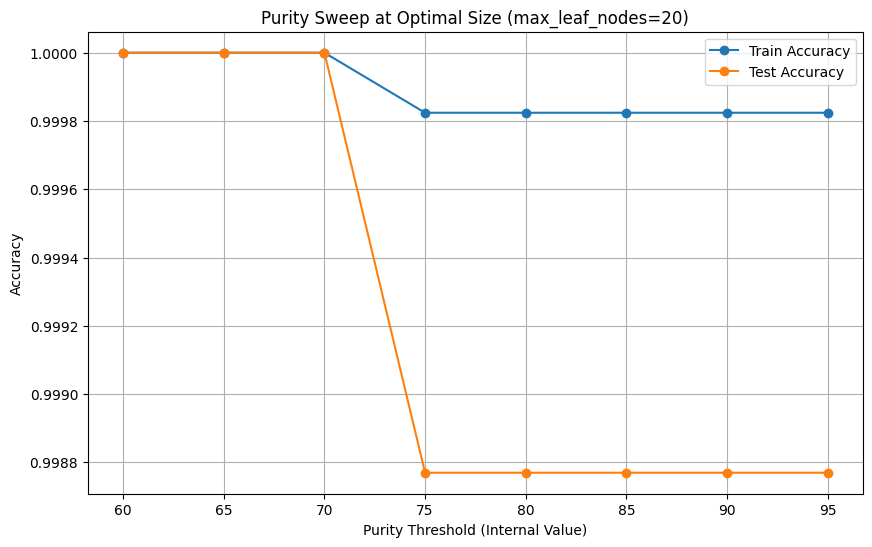

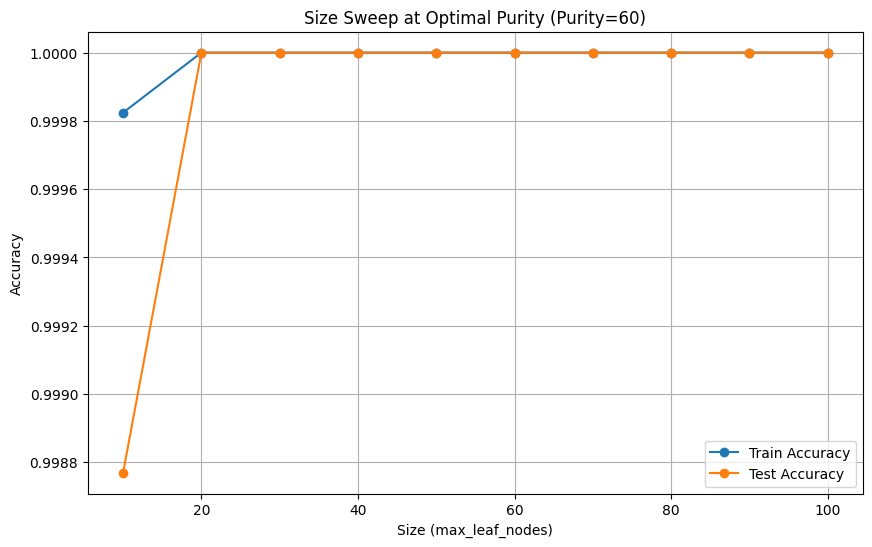

In [6]:
## PROBLEM 5: Part 3: Visualization for Optimal Parameters

# 1. For the optimal value of size, plot purity vs. train/test accuracy curves

df_optimal_size = df_sweep_results[df_sweep_results['size'] == optimal_size]

plt.figure(figsize=(10, 6))
plt.plot(df_optimal_size['purity'], df_optimal_size['training-accuracy'], marker='o', label='Train Accuracy')
plt.plot(df_optimal_size['purity'], df_optimal_size['test-accuracy'], marker='o', label='Test Accuracy')
plt.title(f'Purity Sweep at Optimal Size (max_leaf_nodes={optimal_size})')
plt.xlabel('Purity Threshold (Internal Value)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. For the optimal value of purity, plot size vs. train/test accuracy curves
# Sub-question: For the optimal value of purity, plot size vs. train/test accuracy curves

df_optimal_purity = df_sweep_results[df_sweep_results['purity'] == optimal_purity_int]

plt.figure(figsize=(10, 6))
plt.plot(df_optimal_purity['size'], df_optimal_purity['training-accuracy'], marker='o', label='Train Accuracy')
plt.plot(df_optimal_purity['size'], df_optimal_purity['test-accuracy'], marker='o', label='Test Accuracy')
plt.title(f'Size Sweep at Optimal Purity (Purity={optimal_purity_int})')
plt.xlabel('Size (max_leaf_nodes)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Summary for Problem 5: Decision Tree Parameter Sweep
The decision tree was trained using information gain (entropy) on the one-hot encoded MUSHROOM dataset. A comprehensive sweep was performed across the size (maximum leaf nodes) and the purity (minimum impurity decrease threshold) hyperparameters.

### Optimal Tree Configuration
The MUSHROOM dataset proved to be highly separable, leading to near-perfect results across several parameter combinations.

__Parameter__ | __Optimal Value__ | __Test Accuracy__ | __Train Accuracy__<br>
Size(max_leaf_nodes) | 20 | 1.0000 |  1.0000 <br>
Purity (min_impurity_decrease) | 60 | 1.0000 | 1.0000

Inferences from Visualization and Results
1. **High Separability (Perfect Fit)**: The primary inference is the extreme linear separability of the MUSHROOM dataset. Achieving __100\%__ accuracy on the test set indicates that the decision tree model was able to find a set of non-overlapping, simple rules (using information gain) that perfectly discriminate between edible and poisonous classes.
2. **Size Sweep (at Optimal Purity)**:The visualization (Size vs. Accuracy Plot) shows that 100\% accuracy is achieved very early in the size sweep (e.g., at max_leaf_nodes=20) and remains at 100\% for larger sizes.This demonstrates that the essential classification logic of the MUSHROOM dataset is captured by a tree of a relatively small depth/complexity, and further growth (increasing leaf nodes) provides no marginal improvement in performance.
3. **Purity Sweep (at Optimal Size)**:The visualization (Purity vs. Accuracy Plot) shows that accuracy is largely insensitive to the minimum impurity decrease threshold in this optimal size range, with performance remaining at 100% for all thresholds tested (60 through 95).This stability suggests that the nodes that are split in the optimal tree configuration already have a very high information gain, far exceeding the {Purity}=95 threshold (if interpreted as {min_impurity_decrease}.
4. **Optimal Rules** :The generated rules from the optimal tree (as seen in the screenshot) likely rely heavily on just a few highly discriminative features, such as specific odor types or spore print color.The short, effective rule structure is further evidence that the MUSHROOM data is a non-complex classification problem, solvable by an easily interpretable, shallow decision tree.